In [13]:
import numpy as np
import pandas as pd

data = pd.read_csv(r'C:\Users\Gareth.Ahern\Desktop\NonCommercialOver1000\Attempt2\13.csv')
data.head()

,Flight_ID,Position_DateTime,Latitude,Longitude
0,619465375,13/07/2020 09:07,52.35548,0.27679
1,619465375,13/07/2020 09:07,52.36037,0.28023
2,619465375,13/07/2020 09:07,52.36633,0.28447
3,619465375,13/07/2020 09:07,52.37145,0.28808
4,619465375,13/07/2020 09:08,52.38872,0.30212


In [16]:
#Turn our 
#data['geometry'] = gpd.points_from_xy(data.Longitude, data.Latitude)
#gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

from shapely.geometry import Point
print(data)
geometry = [Point(xy) for xy in zip(data.Longitude, data.Latitude)]
gdf = gpd.GeoDataFrame(data.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'}, geometry=geometry)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [12]:
data_with_counties = gpd.sjoin(gdf, street_map, how="inner", op='intersects')
data_with_counties['District'] = data_with_counties['NAME_3']
print(type(data_with_counties))

data_with_counties = data_with_counties[['Flight_ID', 'District']]
print(data_with_counties.head())
data_with_counties = data_with_counties.groupby(['District']).count()
data_with_counties.reset_index(inplace=True)
data_with_counties.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
   Flight_ID             District
0  619465375  East Cambridgeshire
1  619465375  East Cambridgeshire
2  619465375  East Cambridgeshire
3  619465375  East Cambridgeshire
4  619465375  East Cambridgeshire
        Flight_ID  District
10      619465471  Aberdeen
11      619465471  Aberdeen
12      619465471  Aberdeen
13      619465471  Aberdeen
14      619465471  Aberdeen
...           ...       ...
116881  619489901  Aberdeen
116882  619489901  Aberdeen
118691  619473287  Aberdeen
118692  619473287  Aberdeen
118693  619473287  Aberdeen

[797 rows x 2 columns]


,District,Flight_ID
0,Aberdeen,797
1,Aberdeenshire,1745
2,Adur,30
3,Allerdale,61
4,Amber Valley,71


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

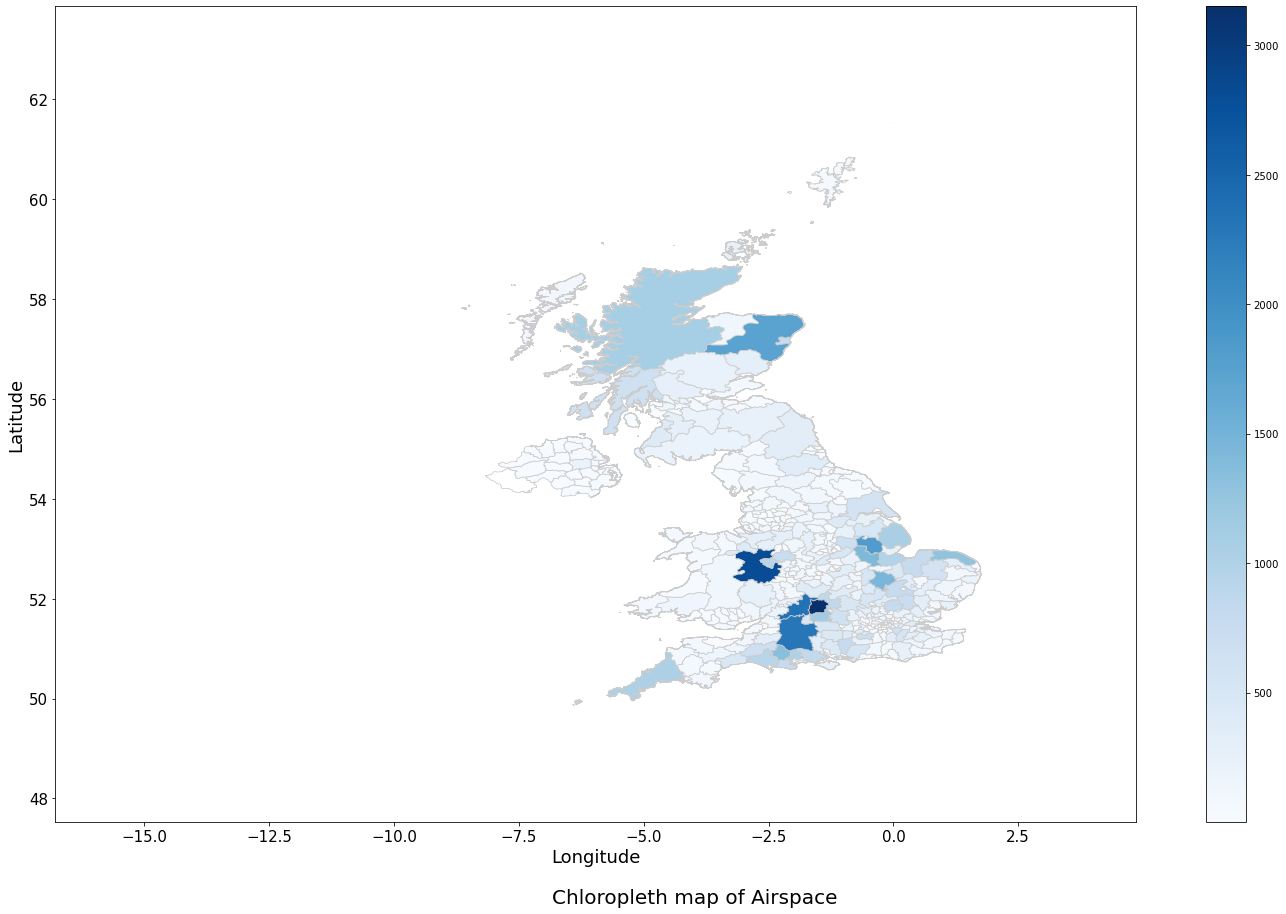

In [90]:
merged_df = street_map.set_index('NAME_3').join(data_with_counties.set_index('District'))
merged_df.reset_index(inplace=True)

fig, ax = plt.subplots(1, figsize=(25, 15))
merged_df['coords'] = merged_df['geometry'].apply(lambda x: x.representative_point().coords[:])
merged_df['coords'] = [coords[0] for coords in merged_df['coords']]

#We can label the areas, but there are too many areas => too many labels, so I wont do this
#for idx, row in merged_df.iterrows():
#    plt.annotate(text=row['NAME_3'], xy=row['coords'], horizontalalignment='center')
    
ax.margins(0.2, 0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
txt='Chloropleth map of Airspace'
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=20)

merged_df.plot(column='Flight_ID', ax=ax, legend=True, cmap='Blues', linewidth=0.8, edgecolor='0.8')